# Paragraph Vector 1-vs-Rest

In [56]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
# General libraries.
import re
import time
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1.1"))
import matplotlib.pyplot as plt
import sys
import gensim
import nltk
import collections
import smart_open
import random

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
from sklearn.svm import LinearSVC
from gensim.models import Word2Vec
from sklearn import metrics
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.grid_search import GridSearchCV
from pprint import pprint
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

# Helper libraries
from shared_lib import utils, vocabulary, tf_embed_viz
nltk.download('stopwords')
reload(utils)

[nltk_data] Downloading package stopwords to /home/nlp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'shared_lib.utils' from 'shared_lib/utils.pyc'>

## 1. Contruct Paragraph2Vec Model

### Preview Input Data

In [57]:
# Get newsgroup data
newsgroup_data_all = fetch_20newsgroups(subset = 'all', remove=('headers', 'footers', 'quotes'))

# List of all the class labels
label_list = list(newsgroup_data_all.target_names)

# Print the class labels
i = 0
for label in label_list:
    print "class: %i\t = %s" %(i, label)
    i += 1

class: 0	 = alt.atheism
class: 1	 = comp.graphics
class: 2	 = comp.os.ms-windows.misc
class: 3	 = comp.sys.ibm.pc.hardware
class: 4	 = comp.sys.mac.hardware
class: 5	 = comp.windows.x
class: 6	 = misc.forsale
class: 7	 = rec.autos
class: 8	 = rec.motorcycles
class: 9	 = rec.sport.baseball
class: 10	 = rec.sport.hockey
class: 11	 = sci.crypt
class: 12	 = sci.electronics
class: 13	 = sci.med
class: 14	 = sci.space
class: 15	 = soc.religion.christian
class: 16	 = talk.politics.guns
class: 17	 = talk.politics.mideast
class: 18	 = talk.politics.misc
class: 19	 = talk.religion.misc


### Select number of classes

In [94]:
from random import randint
random.seed(8)

num_class = 8
randomize = True

if randomize == True:
    label_idxs = []
    label_idxs = random.sample(range(1, 19), num_class)
else:
    label_idxs = range(num_class)

select_classes = [label_list[i] for i in label_idxs]
print "Randomly Select Classes: ", select_classes
print "Class labels", label_idxs

newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'),
                                    categories=select_classes)

all_data, all_labels = newsgroups_all.data, newsgroups_all.target

Randomly Select Classes:  ['comp.windows.x', 'talk.politics.mideast', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'sci.electronics', 'talk.politics.guns']
Class labels [5, 17, 3, 11, 2, 4, 12, 16]


### Preprocess Input Data

In [95]:
#Preprocessing for Doc2Vec 
# shuffle and split data
train_docs, train_labels, test_docs, test_labels = utils.get_train_test_docs(all_data, 
                                                                             all_labels, 
                                                                             split = 0.8, 
                                                                             shuffle = True)

# Further split training set into training and validation set
train_docs, train_labels, validation_docs, validation_labels = utils.get_train_val_docs(train_docs, 
                                                                                         train_labels, 
                                                                                         split = 0.75, 
                                                                                         shuffle = True)
# clean string
# remove stop words and take care of stemming
train_docs = utils.preprocess_doc(train_docs, fix_length = False)
validation_docs = utils.preprocess_doc(validation_docs, fix_length = False)
test_docs = utils.preprocess_doc(test_docs, fix_length = False)

Loaded 7743 docs (9.81227e+06 tokens)
Training set: 6194 docs (7789033 tokens)
Test set: 1549 docs (2023239 tokens)
Loaded 6194 docs (7.78903e+06 tokens)
Training set: 4955 docs (6043595 tokens)
Validation set: 1239 docs (1745438 tokens)


** Please Note LabeledSentence is a data structure of gesim's Doc2vec (paragraph) document format **

In [96]:
from collections import namedtuple
from gensim.models.doc2vec import  LabeledSentence
import sys

all_newsgroup_documents = []

#Used to convert newsgroup corpus into Doc2Vec formats
def convert_newsgroup(docs,split):
    #global doc_count
    tagged_documents = []
    
    for i,v in enumerate(docs):
        label = '%s_%s'%(split,i)
        tagged_documents.append(LabeledSentence(v, [label]))
    
    return tagged_documents

In [97]:
test_docs = convert_newsgroup(test_docs,'test')
validation_docs = convert_newsgroup(validation_docs,'validation')
train_docs = convert_newsgroup(train_docs,'train')

all_newsgroup_documents.extend(train_docs)
all_newsgroup_documents.extend(validation_docs)
all_newsgroup_documents.extend(test_docs)

doc_list = all_newsgroup_documents[:]  # for reshuffling per pass

print('%d docs: %d train, %d validation, %d test' % (len(doc_list), len(train_docs), len(validation_docs), len(test_docs)))

7743 docs: 4955 train, 1239 validation, 1549 test



### Define Paragraph2Vec Model

In [98]:
from gensim.models import *
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

# Doc2Vec Parameter
# dm = 0 use distributed bag of words, dm=1 distributed memory
dm_model = Doc2Vec(dm=1, dm_mean=1, sample=1e-5, size=450, window=10, 
                   negative=5, hs=0, min_count=2, workers=10, max_vocab_size = 20000)
dm_model.build_vocab(all_newsgroup_documents)

### Training Paragraph2Vec Model

### Please note

* Paragraph2vec only the vocabulary of giving data set
* e.g. to train 5 + 1, select num_class = 6, to train 5 + 2, select num_class = 7

In [99]:
from random import shuffle
import progressbar
alpha, min_alpha, passes = (0.025, 0.001, 100)
alpha_delta = (alpha - min_alpha) / passes
bar = progressbar.ProgressBar()

for epoch in bar(range(passes)):
    shuffle(doc_list)
    
    dm_model.alpha, dm_model.min_alpha = alpha, alpha
    dm_model.train(doc_list, total_examples=len(doc_list), epochs = 1)
    alpha -= alpha_delta

100% |########################################################################|


### Extract training and test vectors from the Paragraph2Vec Model

In [100]:
from collections import defaultdict
best_error = defaultdict(lambda :1.0)

#Get Vectors From Doc2Vec
def extract_vectors(model, docs):    
    vectors_list = []
    for doc_no in range(len(docs)):
        doc_label = docs[doc_no].tags[0] # Use tag to id
        doc_vector = model.docvecs[doc_label]
        vectors_list.append(doc_vector)      
    return vectors_list

# TODO inferred vectors
def get_infer_vectors(model,docs):   
    vecs = []
    for doc in docs:
        vecs.append(model.infer_vector(doc.words))
    return vecs

In [101]:
train_docs_ids = np.array(extract_vectors(dm_model,train_docs))
validation_docs_ids = np.array(extract_vectors(dm_model,validation_docs))

# Convert label to one-hot-code
train_labels_oh = np.eye(num_class)[train_labels]
validation_labels_oh = np.eye(num_class)[validation_labels]

print train_docs_ids.shape
print validation_docs_ids.shape
print train_labels_oh.shape
print validation_labels_oh.shape

(4955, 450)
(1239, 450)
(4955, 8)
(1239, 8)


## The following section is for comparing paragraphc2vec's performance with CNN

#### 1. Connect with the same output layer as CNN for classification

#### 2. This is a multi-nomial classification. (not 1-vs-rest)

In [102]:
num_classes = num_class
feature_size = 450
l2_reg_lambda = 0.1

def display_params():
    print "number of classes: ", num_classes
    print "feature size: ", feature_size
    print "regularization: ", l2_reg_lambda

In [103]:
# x_ is the Paragraph2vec input vectors
x_ = tf.placeholder(tf.float32, [None, feature_size], name="x")
y_ = tf.placeholder(tf.float32, [None, num_classes], name="y")
l2_loss = tf.constant(0.0)

# Output Layer: Softmax (1 layer version)
with tf.name_scope("Output_layer"):
            
    
    Z_ = tf.Variable(tf.random_uniform([feature_size, num_classes], -1.0, 1.0), name = "Z")
    b_ = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
    logits_ = tf.add(tf.matmul(x_, Z_), b_, name="logits")
    
    # L2 loss
    l2_loss += tf.nn.l2_loss(Z_)
    l2_loss += tf.nn.l2_loss(b_)
    
    #scores = tf.nn.xw_plus_b(h_drop, W, b, name="scores")
    predictions_ = tf.argmax(logits_, 1, name="predictions")

    
# Calculate mean cross-entropy loss
with tf.name_scope("cost_function"):
    per_example_losses_ = tf.nn.softmax_cross_entropy_with_logits(logits=logits_, 
                                                                 labels=y_,
                                                                 name="per_example_loss")
    loss_ = tf.reduce_mean(per_example_losses_) + l2_reg_lambda * l2_loss

# Accuracy
with tf.name_scope("accuracy"):
    correct_predictions_ = tf.equal(predictions_, tf.argmax(y_, 1))
    accuracy_ = tf.reduce_mean(tf.cast(correct_predictions_, "float"), name="accuracy")
    
with tf.name_scope("Training"):
    alpha_ = tf.placeholder(tf.float32, name="learning_rate")
    optimizer_ = tf.train.AdagradOptimizer(alpha_)
    #optimizer_ = tf.train.AdamOptimizer(alpha_)
    train_step_ = optimizer_.minimize(loss_)
    
# Initializer step
init_ = tf.global_variables_initializer()

### Training

In [104]:
# Helper functions for training
def train_batch(session, batch, alpha):
    # Feed last column as targets
    feed_dict = {x_:train_docs_ids,
                 y_:train_labels_oh,
                 alpha_:alpha}
    c, a, pred, _ = session.run([loss_, accuracy_, predictions_, train_step_],
                       feed_dict=feed_dict)
    return c, a, pred

def batch_generator(data, batch_size):
    """Generate minibatches from data."""
    for i in xrange(0, len(data), batch_size):
        yield data[i:i+batch_size]

def predict_batch(session):
    feed_dict = {x_:validation_docs_ids,
                 y_:validation_labels_oh}
    a, pred = session.run([accuracy_, predictions_], feed_dict=feed_dict)
    return a, pred

In [105]:
display_params()

number of classes:  8
feature size:  450
regularization:  0.1


In [106]:
from shared_lib import utils

def run_epochs(num_epochs, batch_size, learning_rate, min_learning, print_rate):
    # One epoch = one pass through the training data
    num_epochs = num_epochs
    batch_size = batch_size
    alpha = learning_rate  # learning rate
    min_alpha = min_learning
    alpha_delta = (alpha - min_alpha) / num_epochs
    print_every = print_rate

    np.random.seed(42)

    # For plotting
    train_accuracy = []
    validation_accuracy = []

    session = tf.Session()
    session.run(init_)

    t0 = time.time()
    for epoch in xrange(1,num_epochs+1):
        t0_epoch = time.time()
        epoch_cost = 0.0
        total_batches = 0
        print ""
        print "---------- Test ----------"
        print "[epoch %d] Learning Rate %.2f" %(epoch, alpha)
        for i, batch in enumerate(batch_generator(train_docs_ids, batch_size)):
            if (i % print_every == 0):
                print "[epoch %d] seen %d minibatches" % (epoch, i)

            cost, accuracy, pred = train_batch(session, batch, alpha)
            epoch_cost += cost
            total_batches = i + 1

        avg_cost = epoch_cost / total_batches
        alpha = alpha - alpha_delta

        print "[epoch %d] Completed %d minibatches in %s" % (epoch, i, utils.pretty_timedelta(since=t0_epoch))
        print "[epoch %d] Average cost: %.03f" % (epoch, avg_cost,)
        print "[epoch %d] Accuracy %.03f" %(epoch, accuracy)
        print "[epoch %d] Classificaiton Report\n" %(epoch)
        print classification_report(train_labels, pred)
        train_accuracy.append(accuracy)

        print ""
        print "---------- Test ----------"
        accuracy, pred = predict_batch(session)
        print "[epoch %d] Validation Accuracy is %.03f" %(epoch, accuracy)
        print "[epoch %d] Validation Classificaiton Report\n" %(epoch)
        print classification_report(validation_labels, pred)
        validation_accuracy.append(accuracy)
    return train_accuracy, validation_accuracy

def plot_learning(num_epochs, train_accuracy, validation_accuracy):
    plt.figure(figsize=(10, 8))
    plt.plot(range(0, num_epochs), train_accuracy, '.-', label = "Training accuracy")
    plt.plot(range(0, num_epochs), validation_accuracy, '.-', label = "Validation accuracy")
    plt.legend()
    plt.show()

** running epochs **

In [107]:
epochs = 12

In [108]:
train_accur, validation_accur = run_epochs(num_epochs = epochs, 
                                           batch_size = 100, 
                                           learning_rate = 0.5, 
                                           min_learning = 0.1, 
                                           print_rate = 100)


---------- Test ----------
[epoch 1] Learning Rate 0.50
[epoch 1] seen 0 minibatches
[epoch 1] Completed 49 minibatches in 0:00:01
[epoch 1] Average cost: 5.999
[epoch 1] Accuracy 0.701
[epoch 1] Classificaiton Report

             precision    recall  f1-score   support

          0       0.53      0.62      0.57       643
          1       0.64      0.61      0.63       624
          2       0.76      0.57      0.65       606
          3       0.69      0.86      0.77       658
          4       0.75      0.73      0.74       639
          5       0.67      0.67      0.67       615
          6       0.79      0.75      0.77       594
          7       0.86      0.78      0.82       576

avg / total       0.71      0.70      0.70      4955


---------- Test ----------
[epoch 1] Validation Accuracy is 0.666
[epoch 1] Validation Classificaiton Report

             precision    recall  f1-score   support

          0       0.49      0.62      0.55       148
          1       0.58      0

[epoch 7] Completed 49 minibatches in 0:00:01
[epoch 7] Average cost: 1.668
[epoch 7] Accuracy 0.701
[epoch 7] Classificaiton Report

             precision    recall  f1-score   support

          0       0.54      0.62      0.58       643
          1       0.64      0.61      0.63       624
          2       0.76      0.57      0.65       606
          3       0.69      0.86      0.77       658
          4       0.75      0.73      0.74       639
          5       0.67      0.67      0.67       615
          6       0.79      0.75      0.77       594
          7       0.86      0.78      0.82       576

avg / total       0.71      0.70      0.70      4955


---------- Test ----------
[epoch 7] Validation Accuracy is 0.665
[epoch 7] Validation Classificaiton Report

             precision    recall  f1-score   support

          0       0.49      0.62      0.55       148
          1       0.58      0.49      0.53       152
          2       0.70      0.54      0.61       158
         

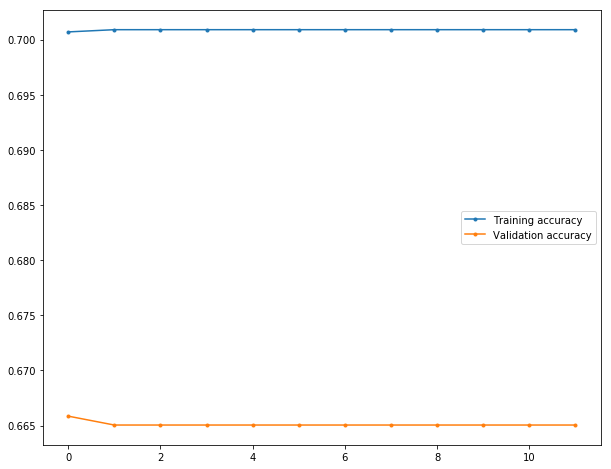

In [109]:
plot_learning(num_epochs = epochs,
              train_accuracy = train_accur, 
              validation_accuracy = validation_accur)

## 2. Open Classificaiton Methods (1-vs-Rest)


* 1-vs-Rest Layer of DOC

    * M (number of class) sigmoid function, N (batch_size)
    * Objective function for training is $$loss = \sum_{i=1}^M \sum_{i=1}^N y_n log(p) + (1 - y_n)log(1 - p(y))$$ is the summation of all log loss (cross-entropy) on the training data.
    * At prediction, reject if all predicted probability is less than their threshold t_i, otherwise $argmax(Sigmoid(d))$
    * The theshold is determined by using outlier detection. (***We can use a fixed number such as 0.95 to validate our model implementation***)
    * Approach:
        1. Remove some classes from the training data
        2. Training the data
        3. Add those classes back to the test data

* Clustering Approach
    * KNN
    * Gausian Mix Model
    * Infinite Dirichlet process

## Case 1 (5 labeled + 1 unseen)

In [59]:
print np.unique(train_labels)

[0 1 2 3 4 5]


### Remove some class and cross validate train data for hyper parameters

In [82]:
## Load SKlearn libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score

** Training and test data are feature vectors from paragraph2vec model **

In [61]:
## Training and test data are feature vectors from paragraph2vec model
train_vectors = extract_vectors(dm_model,train_docs)
test_vectors = extract_vectors(dm_model,test_docs)

# Define a missing class and remove those data from the training set
missing_class = np.array([0])
missing_class_idx = np.where(np.isin(train_labels, missing_class))[0]
train_new_vectors = [train_vectors[i] for i in range(len(train_vectors)) if i not in missing_class_idx]
train_new_labels = [train_labels[i] for i in range(len(train_labels)) if i not in missing_class_idx]

train_valid_cut = int(len(train_new_vectors)*.75)
train_final_vectors = train_new_vectors[:train_valid_cut]
train_final_labels = train_new_labels[:train_valid_cut]

valid_final_vectors=train_new_vectors[train_valid_cut:]
valid_final_labels = train_new_labels[train_valid_cut:]

print np.array(train_vectors).shape
print np.array(test_vectors).shape

(3641, 450)
(1138, 450)


In [62]:
clf_svc = OneVsRestClassifier(SVC(probability=True))
clf_svc.fit(train_final_vectors, train_final_labels)

parameters_SVC = {
    "estimator__C": [0.001,0.01,0.1,0.5,1,2,5],
    "estimator__kernel": ["poly","rbf", "sigmoid","linear"],
    "estimator__degree":[1, 2, 3, 4],
}

print "--- 1-vs-Rest SVM ---"
mod_svc = GridSearchCV(estimator=clf_svc, param_grid=parameters_SVC, scoring='f1_macro', verbose=True)
mod_svc.fit(valid_final_vectors, valid_final_labels)
print mod_svc.best_score_ 
print mod_svc.best_params_

--- 1-vs-Rest SVM ---
Fitting 3 folds for each of 112 candidates, totalling 336 fits


/home/qianyu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed: 11.7min finished


0.64565822354
{'estimator__kernel': 'linear', 'estimator__C': 1, 'estimator__degree': 1}


In [63]:
print np.unique(train_final_labels)
print np.unique(test_labels)

[1 2 3 4 5]
[0 1 2 3 4 5]


### Calibrate 1-vs-Rest probability

In [64]:
clf_svc = OneVsRestClassifier(SVC(probability=True, 
                              kernel=mod_svc.best_params_['estimator__kernel'], 
                              C=mod_svc.best_params_['estimator__C'], 
                              degree=mod_svc.best_params_['estimator__degree']))

clf_svc.fit(train_final_vectors, train_final_labels)

## Calibrate prob
sig_clf_svc = CalibratedClassifierCV(clf_svc, method="sigmoid", cv="prefit")
sig_clf_svc.fit(valid_final_vectors, valid_final_labels)
sig_clf_svc_probs = sig_clf_svc.predict_proba(test_vectors)
clf_svc_probs = clf_svc.predict_proba(test_vectors)

/home/qianyu/anaconda2/lib/python2.7/site-packages/sklearn/calibration.py:432: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/qianyu/anaconda2/lib/python2.7/site-packages/sklearn/calibration.py:442: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/qianyu/anaconda2/lib/python2.7/site-packages/sklearn/calibration.py:444: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


### Visualized histogram of max probability (probability that determine the class)

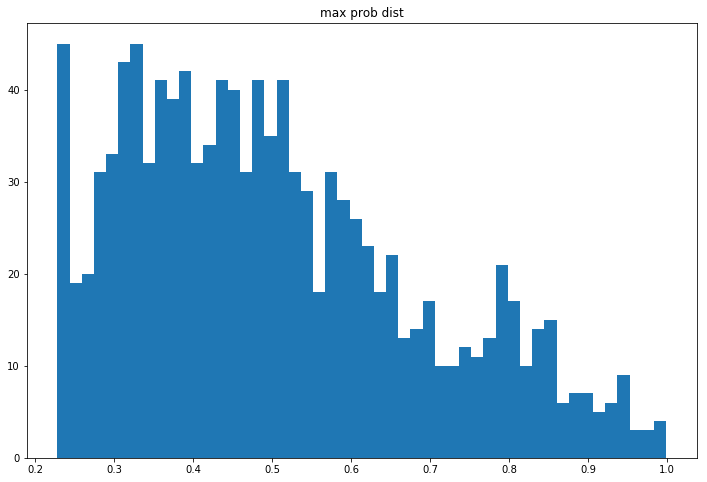

In [65]:
x = np.amax(sig_clf_svc_probs, axis = 1)
plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(x, 50)
plt.title("max prob dist")
plt.show()

### Check Classification Accuracy on Test Data

* Test Data actually have 5 class labels
* Try with training data of 4 labels first

In [66]:
preds1 = clf_svc.predict(test_vectors)
preds2 = sig_clf_svc.predict(test_vectors)
print np.unique(preds1)
print np.unique(preds2)
print classification_report(test_labels,preds1)
print classification_report(test_labels,preds2)
print accuracy_score(test_labels,preds1)
print accuracy_score(test_labels,preds2)

[1 2 3 4 5]
[1 2 3 4 5]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       174
          1       0.51      0.70      0.59       192
          2       0.57      0.60      0.58       199
          3       0.53      0.67      0.60       175
          4       0.67      0.73      0.70       185
          5       0.69      0.79      0.73       213

avg / total       0.51      0.59      0.54      1138

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       174
          1       0.54      0.70      0.61       192
          2       0.50      0.68      0.58       199
          3       0.56      0.67      0.61       175
          4       0.69      0.69      0.69       185
          5       0.74      0.75      0.74       213

avg / total       0.51      0.59      0.55      1138

0.592267135325
0.594024604569


/home/qianyu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### To find the new class, we select a Percentile for Probability Threshold for Class Labels

In [71]:
class_prob_percentile_90 = np.array([np.percentile(sig_clf_svc_probs[:,val], 90.0) 
                                     for val in range(len(sig_clf_svc_probs[0]))])

test_class_preds = np.greater_equal(sig_clf_svc_probs,class_prob_percentile_90).astype(int)

# Predict the test label based on percental
# If a data is below 80% for prob of all class, it belongs to open class
valid_class_probs = np.multiply(sig_clf_svc_probs, test_class_preds)
valid_class = np.greater_equal(np.ceil(valid_class_probs),1).astype(int)
predicted_multinomial = np.multiply(valid_class, np.unique(train_final_labels))
predicted_test_class = np.max(predicted_multinomial,axis=1)

# The true unseen class index
unseen_class_indices = np.where(np.isin(test_labels, missing_class))[0]

In [72]:
np.unique(predicted_test_class), np.unique(train_final_labels)

(array([0, 1, 2, 3, 4, 5]), array([1, 2, 3, 4, 5]))

### Evaluate F1 Score/Precision/Recall with Unseen Class

In [73]:
missing_class_idx_test = np.where(np.isin(test_labels, missing_class))[0]
for i in range(len(test_labels)): 
    if i in missing_class_idx_test:
        test_labels[i] = 0

In [74]:
print classification_report(test_labels, predicted_test_class)
print accuracy_score(test_labels, predicted_test_class)

             precision    recall  f1-score   support

          0       0.25      0.80      0.38       174
          1       0.80      0.47      0.59       192
          2       0.73      0.42      0.53       199
          3       0.64      0.41      0.50       175
          4       0.82      0.51      0.63       185
          5       0.89      0.48      0.62       213

avg / total       0.70      0.51      0.55      1138

0.510544815466


### Unseen Class Predictions

In [75]:
print np.bincount(sorted(predicted_test_class[unseen_class_indices]))
print sum(np.bincount(sorted(predicted_test_class[unseen_class_indices])))

[140   8   6  10   5   5]
174


# Unseen Class Prediction Accuracy

In [76]:
print float(np.bincount(sorted(predicted_test_class[unseen_class_indices]))[0]), \
    sum(np.isin(test_labels, missing_class).astype(int))
print float(np.bincount(sorted(predicted_test_class[unseen_class_indices]))[0])/sum(np.isin(test_labels, missing_class).astype(int))

140.0 174
0.804597701149


## Case 2 (5 labeled + 2 unseen)

In [93]:
print np.unique(train_labels)

[0 1 2 3 4 5 6]


### Remove some class and cross validate train data for hyper parameters

** Training and test data are feature vectors from paragraph2vec model **

In [95]:
## Training and test data are feature vectors from paragraph2vec model
train_vectors = extract_vectors(dm_model,train_docs)
test_vectors = extract_vectors(dm_model,test_docs)

# Define a missing class and remove those data from the training set
missing_class = np.array([0, 1])
missing_class_idx = np.where(np.isin(train_labels, missing_class))[0]
train_new_vectors = [train_vectors[i] for i in range(len(train_vectors)) if i not in missing_class_idx]
train_new_labels = [train_labels[i] for i in range(len(train_labels)) if i not in missing_class_idx]

train_valid_cut = int(len(train_new_vectors)*.75)
train_final_vectors = train_new_vectors[:train_valid_cut]
train_final_labels = train_new_labels[:train_valid_cut]

valid_final_vectors=train_new_vectors[train_valid_cut:]
valid_final_labels = train_new_labels[train_valid_cut:]

print np.array(train_vectors).shape
print np.array(test_vectors).shape

(4265, 450)
(1333, 450)


In [96]:
clf_svc = OneVsRestClassifier(SVC(probability=True))
clf_svc.fit(train_final_vectors, train_final_labels)

parameters_SVC = {
    "estimator__C": [0.001,0.01,0.1,0.5,1,2,5],
    "estimator__kernel": ["poly","rbf", "sigmoid","linear"],
    "estimator__degree":[1, 2, 3, 4],
}

print "--- 1-vs-Rest SVM ---"
mod_svc = GridSearchCV(estimator=clf_svc, param_grid=parameters_SVC, scoring='f1_macro', verbose=True)
mod_svc.fit(valid_final_vectors, valid_final_labels)
print mod_svc.best_score_ 
print mod_svc.best_params_

--- 1-vs-Rest SVM ---
Fitting 3 folds for each of 112 candidates, totalling 336 fits


[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed: 11.3min finished


0.694632064874
{'estimator__kernel': 'linear', 'estimator__C': 0.1, 'estimator__degree': 1}


In [97]:
print np.unique(train_final_labels)
print np.unique(test_labels)

[2 3 4 5 6]
[0 1 2 3 4 5 6]


### Calibrate 1-vs-Rest probability

In [98]:
clf_svc = OneVsRestClassifier(SVC(probability=True, 
                              kernel=mod_svc.best_params_['estimator__kernel'], 
                              C=mod_svc.best_params_['estimator__C'], 
                              degree=mod_svc.best_params_['estimator__degree']))

clf_svc.fit(train_final_vectors, train_final_labels)

## Calibrate prob
sig_clf_svc = CalibratedClassifierCV(clf_svc, method="sigmoid", cv="prefit")
sig_clf_svc.fit(valid_final_vectors, valid_final_labels)
sig_clf_svc_probs = sig_clf_svc.predict_proba(test_vectors)
clf_svc_probs = clf_svc.predict_proba(test_vectors)

### Visualized histogram of max probability (probability that determine the class)

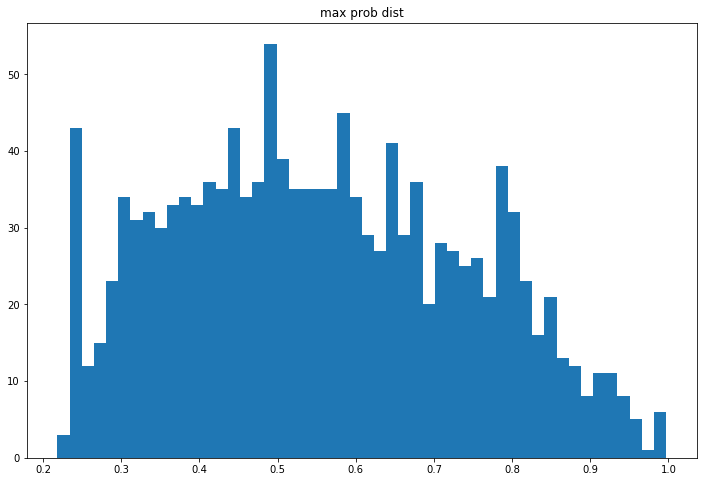

In [99]:
x = np.amax(sig_clf_svc_probs, axis = 1)
plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(x, 50)
plt.title("max prob dist")
plt.show()

### Check Classification Accuracy on Test Data

* Test Data actually have 5 class labels
* Try with training data of 4 labels first

In [100]:
preds1 = clf_svc.predict(test_vectors)
preds2 = sig_clf_svc.predict(test_vectors)
print np.unique(preds1)
print np.unique(preds2)
print classification_report(test_labels,preds1)
print classification_report(test_labels,preds2)
print accuracy_score(test_labels,preds1)
print accuracy_score(test_labels,preds2)

[2 3 4 5 6]
[2 3 4 5 6]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       156
          1       0.00      0.00      0.00       197
          2       0.49      0.59      0.53       221
          3       0.56      0.58      0.57       201
          4       0.56      0.71      0.62       180
          5       0.43      0.88      0.58       180
          6       0.65      0.83      0.73       198

avg / total       0.39      0.52      0.44      1333

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       156
          1       0.00      0.00      0.00       197
          2       0.52      0.56      0.54       221
          3       0.45      0.64      0.53       201
          4       0.61      0.66      0.63       180
          5       0.43      0.89      0.58       180
          6       0.67      0.82      0.74       198

avg / total       0.39      0.52      0.44      1333

0.523630907727
0

### To find the new class, we select a Percentile for Probability Threshold for Class Labels

In [101]:
class_prob_percentile_90 = np.array([np.percentile(sig_clf_svc_probs[:,val], 90.0) 
                                     for val in range(len(sig_clf_svc_probs[0]))])

test_class_preds = np.greater_equal(sig_clf_svc_probs,class_prob_percentile_90).astype(int)

# Predict the test label based on percental
# If a data is below 80% for prob of all class, it belongs to open class
valid_class_probs = np.multiply(sig_clf_svc_probs, test_class_preds)
valid_class = np.greater_equal(np.ceil(valid_class_probs),1).astype(int)
predicted_multinomial = np.multiply(valid_class, np.unique(train_final_labels))
predicted_test_class = np.max(predicted_multinomial,axis=1)

# The true unseen class index
unseen_class_indices = np.where(np.isin(test_labels, missing_class))[0]

In [102]:
np.unique(predicted_test_class), np.unique(train_final_labels)

(array([0, 2, 3, 4, 5, 6]), array([2, 3, 4, 5, 6]))

### Evaluate F1 Score/Precision/Recall with Unseen Class

In [103]:
missing_class_idx_test = np.where(np.isin(test_labels, missing_class))[0]
for i in range(len(test_labels)): 
    if i in missing_class_idx_test:
        test_labels[i] = 0

In [104]:
print classification_report(test_labels, predicted_test_class)
print accuracy_score(test_labels, predicted_test_class)

             precision    recall  f1-score   support

          0       0.39      0.73      0.51       353
          2       0.66      0.39      0.49       221
          3       0.72      0.48      0.57       201
          4       0.71      0.53      0.61       180
          5       0.80      0.59      0.68       180
          6       0.90      0.61      0.73       198

avg / total       0.66      0.57      0.58      1333

0.573893473368


### Unseen Class Predictions

In [105]:
print np.bincount(sorted(predicted_test_class[unseen_class_indices]))
print sum(np.bincount(sorted(predicted_test_class[unseen_class_indices])))

[259   0  30  16  22  22   4]
353


# Unseen Class Prediction Accuracy

In [106]:
print float(np.bincount(sorted(predicted_test_class[unseen_class_indices]))[0]), \
    sum(np.isin(test_labels, missing_class).astype(int))
print float(np.bincount(sorted(predicted_test_class[unseen_class_indices]))[0])/sum(np.isin(test_labels, missing_class).astype(int))

259.0 353
0.733711048159


## Case 3 (5 labeled + 3 unseen)

In [110]:
print np.unique(train_labels)

[0 1 2 3 4 5 6 7]


### Remove some class and cross validate train data for hyper parameters

** Training and test data are feature vectors from paragraph2vec model **

In [111]:
## Training and test data are feature vectors from paragraph2vec model
train_vectors = extract_vectors(dm_model,train_docs)
test_vectors = extract_vectors(dm_model,test_docs)

# Define a missing class and remove those data from the training set
missing_class = np.array([0, 1, 2])
missing_class_idx = np.where(np.isin(train_labels, missing_class))[0]
train_new_vectors = [train_vectors[i] for i in range(len(train_vectors)) if i not in missing_class_idx]
train_new_labels = [train_labels[i] for i in range(len(train_labels)) if i not in missing_class_idx]

train_valid_cut = int(len(train_new_vectors)*.75)
train_final_vectors = train_new_vectors[:train_valid_cut]
train_final_labels = train_new_labels[:train_valid_cut]

valid_final_vectors=train_new_vectors[train_valid_cut:]
valid_final_labels = train_new_labels[train_valid_cut:]

print np.array(train_vectors).shape
print np.array(test_vectors).shape

(4955, 450)
(1549, 450)


In [112]:
clf_svc = OneVsRestClassifier(SVC(probability=True))
clf_svc.fit(train_final_vectors, train_final_labels)

parameters_SVC = {
    "estimator__C": [0.001,0.01,0.1,0.5,1,2,5],
    "estimator__kernel": ["poly","rbf", "sigmoid","linear"],
    "estimator__degree":[1, 2, 3, 4],
}

print "--- 1-vs-Rest SVM ---"
mod_svc = GridSearchCV(estimator=clf_svc, param_grid=parameters_SVC, scoring='f1_macro', verbose=True)
mod_svc.fit(valid_final_vectors, valid_final_labels)
print mod_svc.best_score_ 
print mod_svc.best_params_

--- 1-vs-Rest SVM ---
Fitting 3 folds for each of 112 candidates, totalling 336 fits


[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed: 13.7min finished


0.793218455564
{'estimator__kernel': 'rbf', 'estimator__C': 2, 'estimator__degree': 1}


In [113]:
print np.unique(train_final_labels)
print np.unique(test_labels)

[3 4 5 6 7]
[0 1 2 3 4 5 6 7]


### Calibrate 1-vs-Rest probability

In [114]:
clf_svc = OneVsRestClassifier(SVC(probability=True, 
                              kernel=mod_svc.best_params_['estimator__kernel'], 
                              C=mod_svc.best_params_['estimator__C'], 
                              degree=mod_svc.best_params_['estimator__degree']))

clf_svc.fit(train_final_vectors, train_final_labels)

## Calibrate prob
sig_clf_svc = CalibratedClassifierCV(clf_svc, method="sigmoid", cv="prefit")
sig_clf_svc.fit(valid_final_vectors, valid_final_labels)
sig_clf_svc_probs = sig_clf_svc.predict_proba(test_vectors)
clf_svc_probs = clf_svc.predict_proba(test_vectors)

### Visualized histogram of max probability (probability that determine the class)

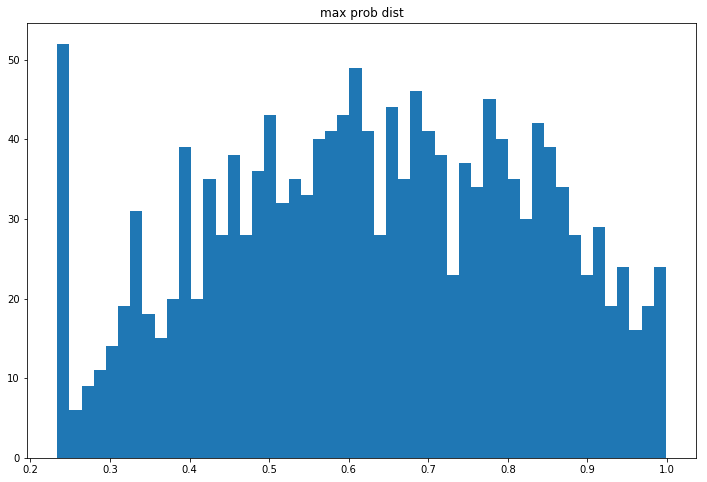

In [115]:
x = np.amax(sig_clf_svc_probs, axis = 1)
plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(x, 50)
plt.title("max prob dist")
plt.show()

### Check Classification Accuracy on Test Data

* Test Data actually have 5 class labels
* Try with training data of 4 labels first

In [116]:
preds1 = clf_svc.predict(test_vectors)
preds2 = sig_clf_svc.predict(test_vectors)
print np.unique(preds1)
print np.unique(preds2)
print classification_report(test_labels,preds1)
print classification_report(test_labels,preds2)
print accuracy_score(test_labels,preds1)
print accuracy_score(test_labels,preds2)

[3 4 5 6 7]
[3 4 5 6 7]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       194
          1       0.00      0.00      0.00       206
          2       0.00      0.00      0.00       199
          3       0.37      0.94      0.53       187
          4       0.71      0.74      0.73       192
          5       0.34      0.80      0.48       200
          6       0.72      0.77      0.75       160
          7       0.76      0.83      0.79       211

avg / total       0.35      0.50      0.40      1549

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       194
          1       0.00      0.00      0.00       206
          2       0.00      0.00      0.00       199
          3       0.42      0.92      0.58       187
          4       0.77      0.73      0.75       192
          5       0.30      0.83      0.45       200
          6       0.70      0.78      0.74       160
          7       

### To find the new class, we select a Percentile for Probability Threshold for Class Labels

In [117]:
class_prob_percentile_90 = np.array([np.percentile(sig_clf_svc_probs[:,val], 90.0) 
                                     for val in range(len(sig_clf_svc_probs[0]))])

test_class_preds = np.greater_equal(sig_clf_svc_probs,class_prob_percentile_90).astype(int)

# Predict the test label based on percental
# If a data is below 80% for prob of all class, it belongs to open class
valid_class_probs = np.multiply(sig_clf_svc_probs, test_class_preds)
valid_class = np.greater_equal(np.ceil(valid_class_probs),1).astype(int)
predicted_multinomial = np.multiply(valid_class, np.unique(train_final_labels))
predicted_test_class = np.max(predicted_multinomial,axis=1)

# The true unseen class index
unseen_class_indices = np.where(np.isin(test_labels, missing_class))[0]

In [118]:
np.unique(predicted_test_class), np.unique(train_final_labels)

(array([0, 3, 4, 5, 6, 7]), array([3, 4, 5, 6, 7]))

### Evaluate F1 Score/Precision/Recall with Unseen Class

In [119]:
missing_class_idx_test = np.where(np.isin(test_labels, missing_class))[0]
for i in range(len(test_labels)): 
    if i in missing_class_idx_test:
        test_labels[i] = 0

In [120]:
print classification_report(test_labels, predicted_test_class)
print accuracy_score(test_labels, predicted_test_class)

             precision    recall  f1-score   support

          0       0.59      0.76      0.66       599
          3       0.69      0.57      0.63       187
          4       0.87      0.69      0.77       192
          5       0.50      0.39      0.44       200
          6       0.79      0.76      0.77       160
          7       0.94      0.69      0.79       211

avg / total       0.69      0.67      0.67      1549

0.671400903809


### Unseen Class Predictions

In [121]:
print np.bincount(sorted(predicted_test_class[unseen_class_indices]))
print sum(np.bincount(sorted(predicted_test_class[unseen_class_indices])))

[455   0   0  47  10  76   7   4]
599


# Unseen Class Prediction Accuracy

In [122]:
print float(np.bincount(sorted(predicted_test_class[unseen_class_indices]))[0]), \
    sum(np.isin(test_labels, missing_class).astype(int))
print float(np.bincount(sorted(predicted_test_class[unseen_class_indices]))[0])/sum(np.isin(test_labels, missing_class).astype(int))

455.0 599
0.75959933222
